In [358]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
matplotlib.rcParams.update({'figure.max_open_warning': 0})
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler, MinMaxScaler, OneHotEncoder, RobustScaler, MaxAbsScaler
from sklearn.metrics import make_scorer
from joblib import Parallel, delayed
from sklearn.pipeline import FeatureUnion, _fit_transform_one, _transform_one
from sklearn.compose import ColumnTransformer
from scipy import sparse
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV

class StandardScalerDf(StandardScaler):
    """
    DataFrame Wrapper around StandardScaler
    http://flennerhag.com/2017-01-08-Recursive-Override/
    """
    def __init__(self, copy=True, with_mean=True, with_std=True):
        super(StandardScalerDf, self).__init__(copy=copy,
                                               with_mean=with_mean,
                                               with_std=with_std)

    def transform(self, X, y=None):
        z = super(StandardScalerDf, self).transform(X.values)
        return pd.DataFrame(z, index=X.index, columns=X.columns)

class OneHotEncodingDf(OneHotEncoder):
    """DataFrame Wrapper around OneHotEncoding"""
    def __init__(self, drop=None, sparse=False, handle_unknown='ignore'):
        super(OneHotEncodingDf, self).__init__(drop=drop,
                                               sparse=sparse,
                                               handle_unknown=handle_unknown
                                              )

    def transform(self, X, y=None):
        z = super(OneHotEncodingDf, self).transform(X.values)
        return pd.DataFrame(z, index=X.index, columns=self.get_feature_names())
    
class PandasFeatureUnion(FeatureUnion):
    def fit_transform(self, X, y=None, **fit_params):
        self._validate_transformers()
        result = Parallel(n_jobs=self.n_jobs)(
            delayed(_fit_transform_one)(
                transformer=trans,
                X=X,
                y=y,
                weight=weight,
                **fit_params)
            for name, trans, weight in self._iter())

        if not result:
            # All transformers are None
            return np.zeros((X.shape[0], 0))
        Xs, transformers = zip(*result)
        self._update_transformer_list(transformers)
        if any(sparse.issparse(f) for f in Xs):
            Xs = sparse.hstack(Xs).tocsr()
        else:
            Xs = self.merge_dataframes_by_column(Xs)
        return Xs

    def merge_dataframes_by_column(self, Xs):
        return pd.concat(Xs, axis="columns", copy=False)

    def transform(self, X):
        Xs = Parallel(n_jobs=self.n_jobs)(
            delayed(_transform_one)(
                transformer=trans,
                X=X,
                y=None,
                weight=weight)
            for name, trans, weight in self._iter())
        if not Xs:
            # All transformers are None
            return np.zeros((X.shape[0], 0))
        if any(sparse.issparse(f) for f in Xs):
            Xs = sparse.hstack(Xs).tocsr()
        else:
            Xs = self.merge_dataframes_by_column(Xs)
        return Xs

# EDA

In [47]:
filename = 'new-york-city-airbnb-open-data/AB_NYC_2019.csv'
data = pd.read_csv(filename)
data = data.drop(columns=['id', 'name', 'host_id', 'host_name', 'last_review'])
data.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355
2,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,1,365
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194
4,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0


In [48]:
data.tail()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
48890,Brooklyn,Bedford-Stuyvesant,40.67853,-73.94995,Private room,70,2,0,NaN,2,9
48891,Brooklyn,Bushwick,40.70184,-73.93317,Private room,40,4,0,NaN,2,36
48892,Manhattan,Harlem,40.81475,-73.94867,Entire home/apt,115,10,0,NaN,1,27
48893,Manhattan,Hell's Kitchen,40.75751,-73.99112,Shared room,55,1,0,NaN,6,2
48894,Manhattan,Hell's Kitchen,40.76404,-73.98933,Private room,90,7,0,NaN,1,23


In [49]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   neighbourhood_group             48895 non-null  object 
 1   neighbourhood                   48895 non-null  object 
 2   latitude                        48895 non-null  float64
 3   longitude                       48895 non-null  float64
 4   room_type                       48895 non-null  object 
 5   price                           48895 non-null  int64  
 6   minimum_nights                  48895 non-null  int64  
 7   number_of_reviews               48895 non-null  int64  
 8   reviews_per_month               38843 non-null  float64
 9   calculated_host_listings_count  48895 non-null  int64  
 10  availability_365                48895 non-null  int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 4.1+ MB


In [50]:
target = 'price'
geo_columns = [
    'latitude',
    'longitude'
]
numeric_columns = [
    'price',
    'minimum_nights',
    'number_of_reviews',
    'reviews_per_month',
    'calculated_host_listings_count',
    'availability_365'
]
object_columns = [
    'neighbourhood_group',
    'neighbourhood',
    'room_type',
]

In [51]:
data.describe(percentiles=[0.05,0.3,0.5,0.7,0.99])

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,38843.000000,48895.000000,48895.000000
mean,40.728949,-73.952170,152.720687,7.029962,23.274466,1.373221,7.143982,112.781327
std,0.054530,0.046157,240.154170,20.510550,44.550582,1.680442,32.952519,131.622289
min,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
5%,40.646114,-74.003880,40.000000,1.000000,0.000000,0.040000,1.000000,0.000000
30%,40.696570,-73.978570,75.000000,2.000000,1.000000,0.260000,1.000000,0.000000
50%,40.723070,-73.955680,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
70%,40.756030,-73.941290,155.000000,4.000000,17.000000,1.690000,2.000000,179.000000
99%,40.864661,-73.776920,799.000000,45.000000,214.000000,7.195800,232.000000,365.000000
max,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


In [52]:
data[data['price'] == 0]

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
23161,Brooklyn,Bedford-Stuyvesant,40.69023,-73.95428,Private room,0,4,1,0.05,4,28
25433,Bronx,East Morrisania,40.83296,-73.88668,Private room,0,2,55,2.56,4,127
25634,Brooklyn,Bushwick,40.69467,-73.92433,Private room,0,2,16,0.71,5,0
25753,Brooklyn,Greenpoint,40.72462,-73.94072,Private room,0,2,12,0.53,2,0
25778,Brooklyn,Williamsburg,40.70838,-73.94645,Entire home/apt,0,5,3,0.15,1,73
25794,Brooklyn,Bedford-Stuyvesant,40.68173,-73.91342,Private room,0,1,93,4.28,6,176
25795,Brooklyn,Bedford-Stuyvesant,40.68279,-73.91170,Private room,0,1,95,4.37,6,232
25796,Brooklyn,Bedford-Stuyvesant,40.68258,-73.91284,Private room,0,1,95,4.35,6,222
26259,Manhattan,Murray Hill,40.75091,-73.97597,Entire home/apt,0,3,0,NaN,1,0
26841,Brooklyn,Bushwick,40.69211,-73.90670,Shared room,0,30,2,0.11,6,333


In [53]:
data[data['reviews_per_month'].isnull()]

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
2,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,1,365
19,Manhattan,East Harlem,40.79685,-73.94872,Entire home/apt,190,7,0,NaN,2,249
26,Manhattan,Inwood,40.86754,-73.92639,Private room,80,4,0,NaN,1,0
36,Brooklyn,Bedford-Stuyvesant,40.68876,-73.94312,Private room,35,60,0,NaN,1,365
38,Brooklyn,Flatbush,40.63702,-73.96327,Private room,150,1,0,NaN,1,365
...,...,...,...,...,...,...,...,...,...,...,...
48890,Brooklyn,Bedford-Stuyvesant,40.67853,-73.94995,Private room,70,2,0,NaN,2,9
48891,Brooklyn,Bushwick,40.70184,-73.93317,Private room,40,4,0,NaN,2,36
48892,Manhattan,Harlem,40.81475,-73.94867,Entire home/apt,115,10,0,NaN,1,27
48893,Manhattan,Hell's Kitchen,40.75751,-73.99112,Shared room,55,1,0,NaN,6,2


In [54]:
data = data.fillna(value=0)
data = data.drop(data[data['price'] == 0].index)

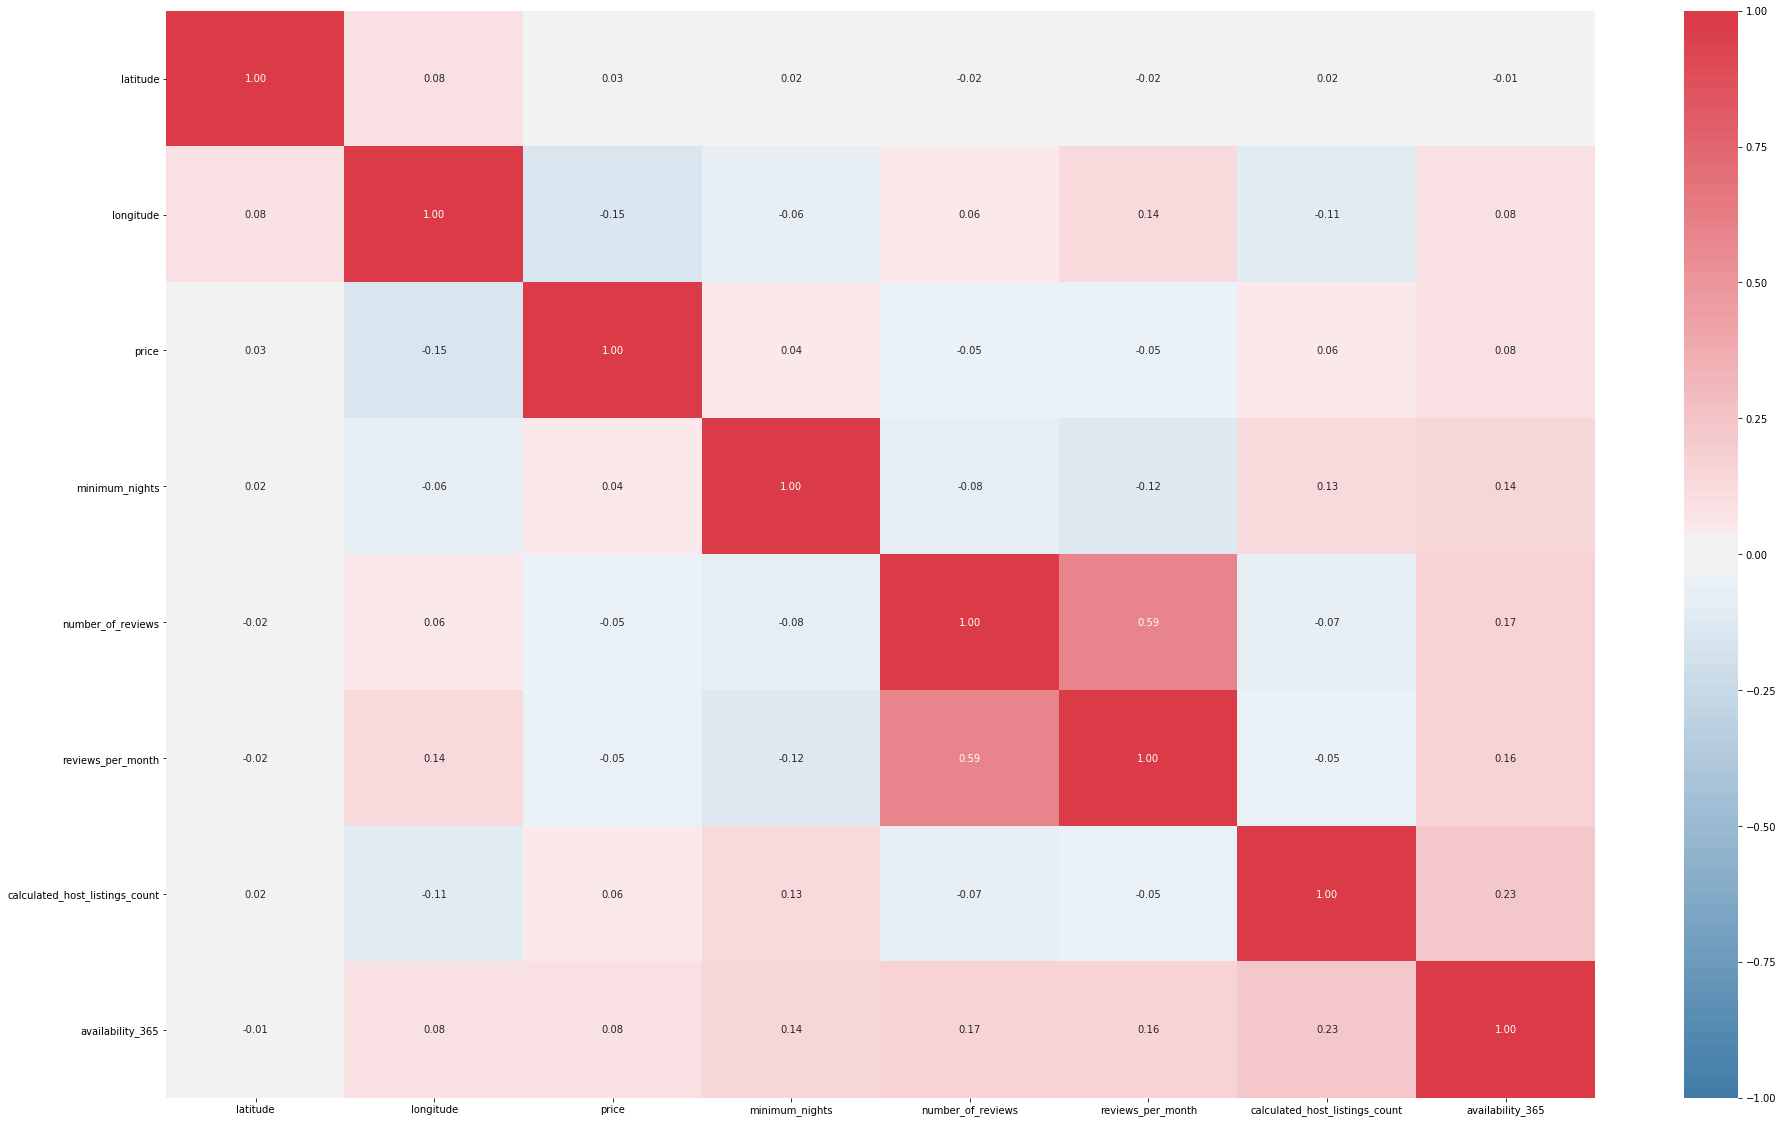

In [55]:
plt.figure(figsize=(32,20));
sns.heatmap(data.corr(), annot=True, fmt='.2f', vmin=-1.0, vmax=1.0, cmap=sns.diverging_palette(240, 10, n=100));

Есть средняя корелляция между количеством отзывов и количеством отзывов за месяц, больше вроде ничего нет (поправьте если я не прав). Видно что на цену больше всего влияет longitude (чем западнее жилье тем оно дешевле).

# Latitude & Longitude

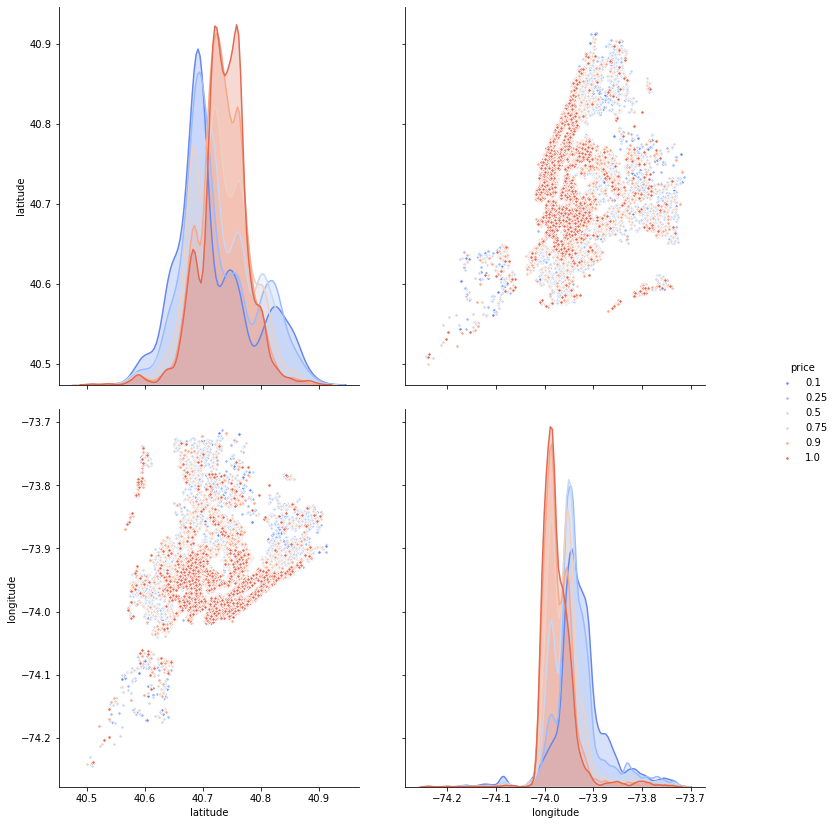

In [56]:
price_quantiles = [0.1, 0.25, 0.5, 0.75, 0.9]
price_quantile_bound_values = data['price'].quantile(price_quantiles)
def price_quantile(value):
    for idx, q_value in enumerate(price_quantile_bound_values):
        if q_value >= value:
            return price_quantiles[idx]
    return 1.0        
price_map_data = data[['latitude', 'longitude']].copy()
price_map_data['price'] = data['price'].apply(price_quantile)
price_map_plt = sns.pairplot(price_map_data, vars=['latitude', 'longitude'], hue='price', palette=sns.color_palette("coolwarm", len(price_quantile_bound_values) + 1), plot_kws={'s': 11})
price_map_plt.fig.set_size_inches(12,12)

На графиках видно, что
1) pairplot между координатами нарисовали по сути карту нью-йорка, а у долготы на всех графиках есть разрыв из-за пролива между лонг айлендом и стейтен айлендом
2) На карте видно что самое дорогое жилье расположено в районах манхеттен и бруклин

# Main Places

In [57]:
times_square = (40.758896, -73.985130)
central_park = (40.785091, -73.968285)
staten_island_mall = (40.58173, -74.165951)
luna_park = (40.575544, -73.970702)
bronx_zoo = (40.852905, -73.872971)

In [58]:
import math
def distance(place):
    return lambda data: math.sqrt(pow((data[0]-place[0]), 2)+pow((data[1]-place[1]), 2))

def make_main_place_transformer(place):
    return FunctionTransformer(lambda data: data[['latitude', 'longitude']].apply(distance(times_square), axis=1).rename('abc'), validate=False)

def make_select(features):
    return FunctionTransformer(lambda data: data[features], validate=False)

def make_drop(features):
    return FunctionTransformer(lambda data: data.drop(features, axis=1), validate=False)

def make_rename(name):
    return FunctionTransformer(lambda data: pd.DataFrame(data.rename(name), columns=[name]), validate=False)

def make_place_selector(name, place):
    return Pipeline([
        ('select geo', make_select(geo_columns)),
        ('transform', make_main_place_transformer(place)),
        ('rename', make_rename(name)),
    ])

times_square_selector = make_place_selector('times_square_distance', times_square)

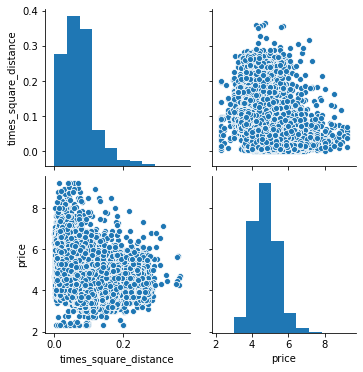

In [59]:
times_square_price = times_square_selector.fit_transform(data)
times_square_price['price'] = data['price'].apply(np.log)
sns.pairplot(times_square_price)

In [60]:
times_square_price.corr()

,times_square_distance,price
times_square_distance,1.000000,-0.391654
price,-0.391654,1.000000


Есть небольшая корреляция между близостью к Times Square и стоимостью жилья (чем ближе тем дороже)

# Numeric

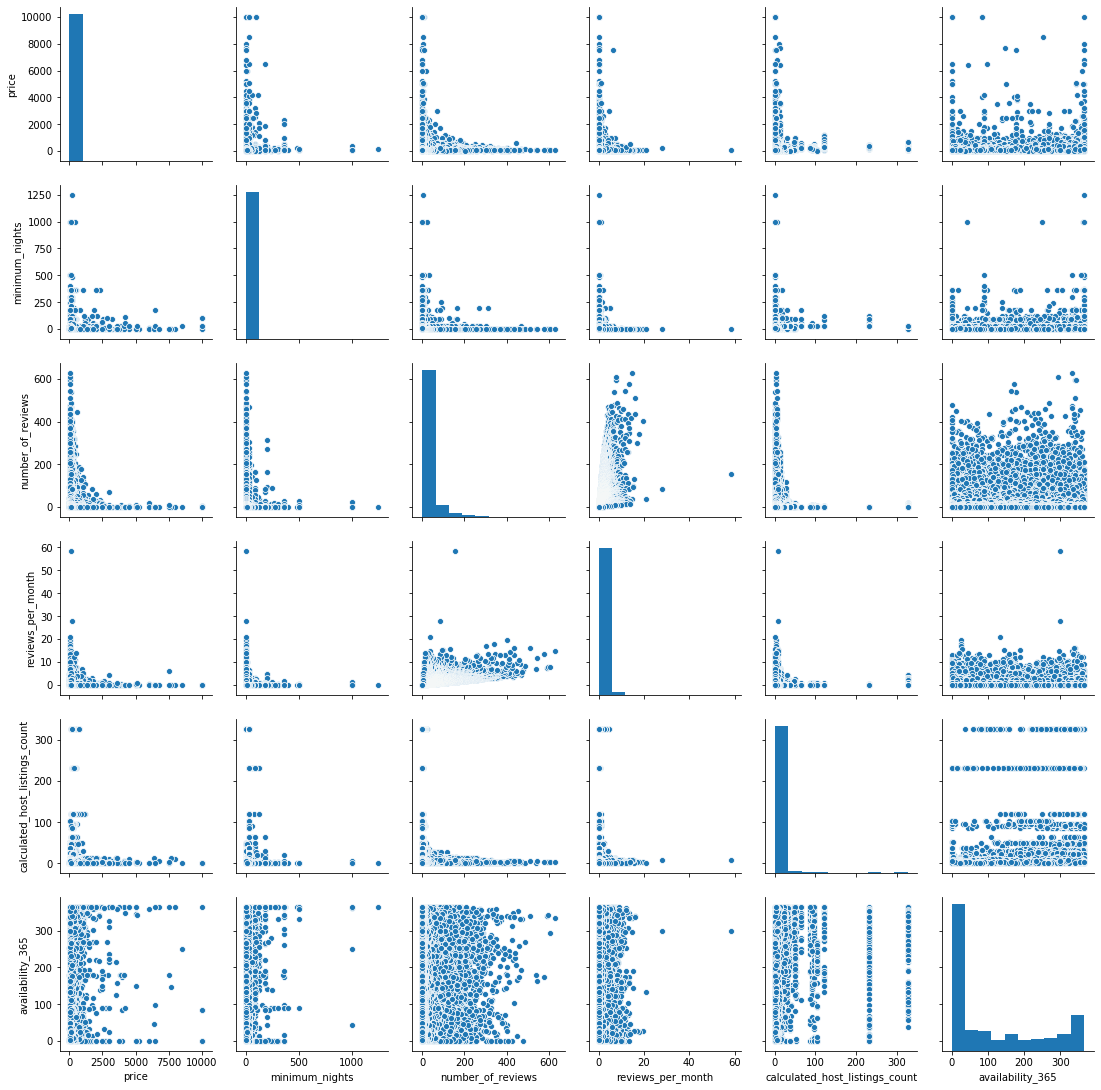

In [61]:
sns.pairplot(data, vars=numeric_columns)

Данные графики показывают, что распределение всех переменных кроме availability смещено влево. Попробую прологарифмировать

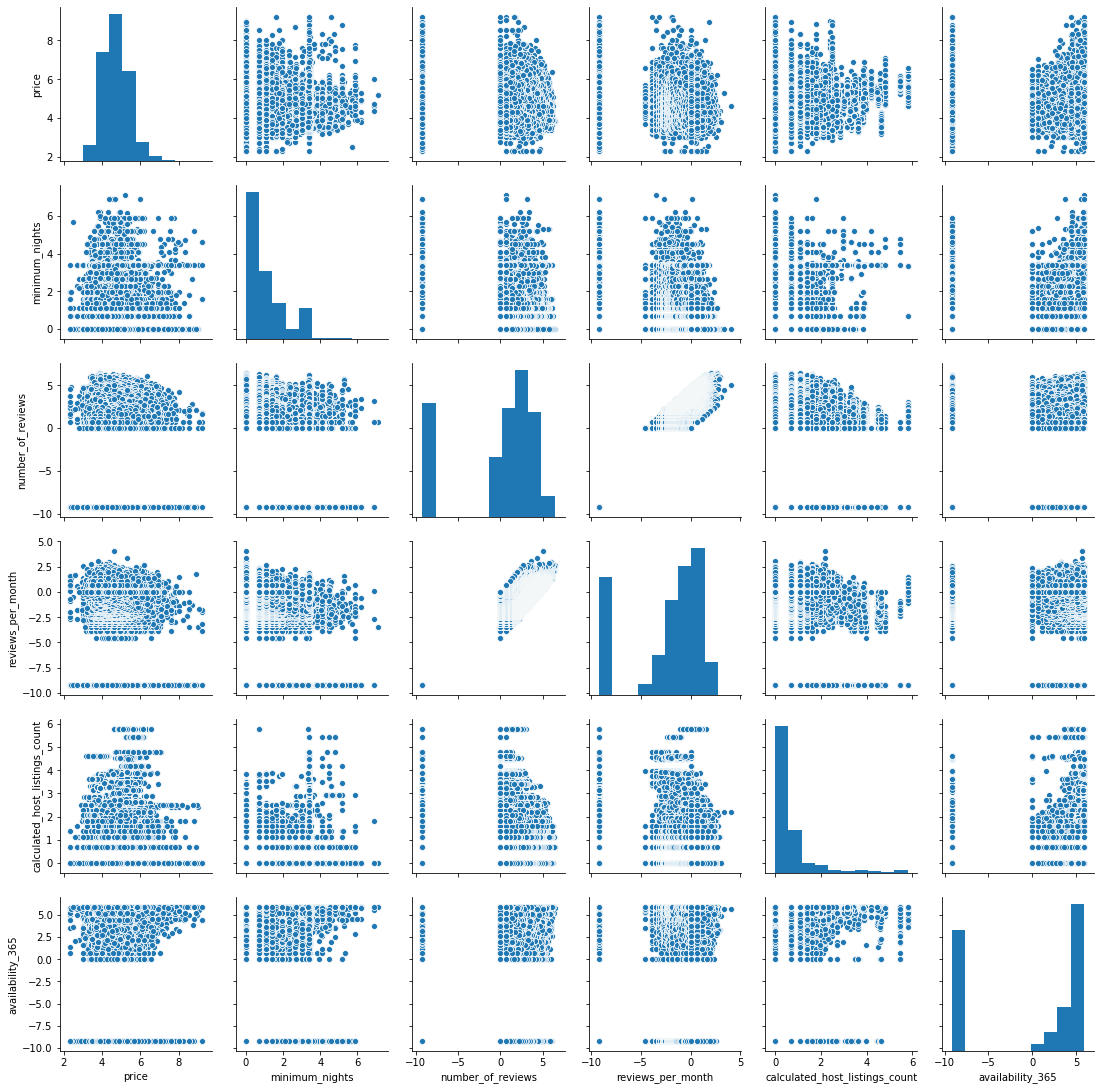

In [62]:
log_data = data[numeric_columns]
log_data += 0.0001
log_data = log_data.apply(np.log)
sns.pairplot(log_data)

В результате логарифмирования я выяснил, что
1) логарифмирование price сделало распределение нормальным
2) в reviews_per_month и number_of_reviews все хорошо, кроме того что есть огромный пик в нуле.
3) распределение calculated_host_listings_count и minimum_nights не стало нормальным
4) availability_365 не нужно логарифмировать

In [63]:
def make_log_transformer():
    return FunctionTransformer(lambda data: pd.DataFrame((data + 0.0001), columns=data.columns).apply(np.log), validate=False)

def make_numeric_selector():
    return Pipeline([
        ('select', PandasFeatureUnion([
            ('log', Pipeline([
                ('select', make_select(['minimum_nights', 'reviews_per_month', 'number_of_reviews', 'calculated_host_listings_count'])),
                ('log', make_log_transformer())
            ])),
            ('plain', make_select(['availability_365'])),
            ('main_place', times_square_selector)
        ])),
        ('scale', StandardScalerDf())
    ])

# Objects

# Room type

In [64]:
objects = data[object_columns]
objects.describe()

,neighbourhood_group,neighbourhood,room_type
count,48884,48884,48884
unique,5,221,3
top,Manhattan,Williamsburg,Entire home/apt
freq,21660,3919,25407


In [65]:
objects['room_type'].value_counts()

Entire home/apt    25407
Private room       22319
Shared room         1158
Name: room_type, dtype: int64

Shared room заметно ниже чем остальных категорий. Возможно имеет смысл объединить его с Private room. Точнее сделать только фичу Entire home.

In [66]:
def make_entire_home_selector():
    return Pipeline([
        ('select room_type', make_select(['room_type'])),
        ('map room_type to entire_home', FunctionTransformer(lambda data: data['room_type'] == 'Entire home/apt', validate=False)),
        ('name column', make_rename('entire_home'))
    ])

# Neighbourhood

In [67]:
objects['neighbourhood_group'].value_counts()

Manhattan        21660
Brooklyn         20095
Queens            5666
Bronx             1090
Staten Island      373
Name: neighbourhood_group, dtype: int64

В бруклине и манхеттене заметно больше жилья чем в остальных районах. Возможно стоит раздробить бруклин и манхеттен на названия районов. Мне необходимо найти пороговое значение по которому я буду выбирать какие районы брать из neighbourhood, а какие из neighbourhood_group. Для этого нужно найти минимально возможное стандартное отклонение в value_counts.

In [68]:
objects['neighbourhood'].value_counts().mean()

221.1945701357466

In [69]:
objects['neighbourhood'].value_counts().median()

32.0

In [70]:
objects['neighbourhood'].value_counts().std()

535.9461499131663

In [71]:
def make_replace_neighbourhood(value):
    def replace(data):
        d = data.copy()
        extracted_neighbourhoods = data['neighbourhood'].value_counts()[data['neighbourhood'].value_counts()>=value].index
        constraint = d['neighbourhood'].isin(extracted_neighbourhoods)
        d.loc[constraint, 'neighbourhood'] = d['neighbourhood']
        d.loc[~constraint, 'neighbourhood'] = d['neighbourhood_group']
        return d
    return replace

def neighbourhood_std(value):
    d = data[['neighbourhood', 'neighbourhood_group']].copy()
    d = make_replace_neighbourhood(value)(d)
    unique_count = len(d['neighbourhood'].value_counts())
    scaler = MinMaxScaler()
    return scaler.fit_transform(d['neighbourhood'].value_counts().values.reshape(-1, 1)).std()

def neighbourhood_unique_count(value):
    d = data[['neighbourhood', 'neighbourhood_group']].copy()
    d = make_replace_neighbourhood(value)(d)
    return len(d['neighbourhood'].value_counts())

In [72]:
std_by_bound = pd.DataFrame(data=np.arange(start=30, stop=1000, step=10), columns=['bound'])
std_by_bound['std'] = std_by_bound['bound'].apply(neighbourhood_std)
std_by_bound['count'] = std_by_bound['bound'].apply(neighbourhood_unique_count)
std_by_bound['count'] = std_by_bound['count'] / len(data['neighbourhood'].value_counts())

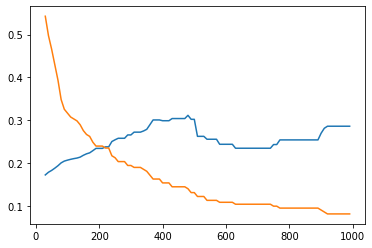

In [73]:
plt.plot(std_by_bound['bound'], std_by_bound['std'])
plt.plot(std_by_bound['bound'], std_by_bound['count'])

Если использовать без MinMaxScaler то получится постоянно возрастающая линия, я так полагаю это из-за того что влияет размер ошибки. Мне же сейчас важен количественный баланс между классами, поэтому я попробовал MinMaxScaler. 

Я вижу локальный минимум в районе 700. Т.е. если всем районам где меньше 700 записей заменить район на обобщенный район то я получу более менее оптимальное соотношение по количеству фич (примерно 25) в датасете и балансом записей. Я не уверен что я делаю что-то правильное, поэтому при проверке дз хотел бы получить фидбек по этому моменту. 

Так же можно попробовать порог равный 200, у нас будет в два с половиной раза больше фич (60-70) чем при 700 записях, но чуть меньшее значение отклоения.

In [74]:
def make_neighbourhood_select(bound):
    return Pipeline([
        ('select', make_select(['neighbourhood', 'neighbourhood_group'])),
        ('transform', FunctionTransformer(make_replace_neighbourhood(bound))),
        ('drop', make_drop('neighbourhood_group')),
        ('ohe', OneHotEncodingDf(sparse=False, handle_unknown='ignore'))
    ])

In [75]:
make_neighbourhood_select(700).fit_transform(data).head()

,x0_Astoria,x0_Bedford-Stuyvesant,x0_Bronx,x0_Brooklyn,x0_Bushwick,x0_Chelsea,x0_Crown Heights,x0_East Harlem,x0_East Village,x0_Financial District,...,x0_Lower East Side,x0_Manhattan,x0_Midtown,x0_Queens,x0_Staten Island,x0_Upper East Side,x0_Upper West Side,x0_Washington Heights,x0_West Village,x0_Williamsburg
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [76]:
make_neighbourhood_select(200).fit_transform(data).head()

,x0_Astoria,x0_Bedford-Stuyvesant,x0_Bronx,x0_Brooklyn,x0_Bushwick,x0_Carroll Gardens,x0_Chelsea,x0_Chinatown,x0_Clinton Hill,x0_Crown Heights,...,x0_Staten Island,x0_Sunnyside,x0_Sunset Park,x0_Theater District,x0_Upper East Side,x0_Upper West Side,x0_Washington Heights,x0_West Village,x0_Williamsburg,x0_Woodside
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [77]:
make_neighbourhood_select(0).fit_transform(data).head()

,x0_Allerton,x0_Arden Heights,x0_Arrochar,x0_Arverne,x0_Astoria,x0_Bath Beach,x0_Battery Park City,x0_Bay Ridge,x0_Bay Terrace,"x0_Bay Terrace, Staten Island",...,x0_Westerleigh,x0_Whitestone,x0_Williamsbridge,x0_Williamsburg,x0_Willowbrook,x0_Windsor Terrace,x0_Woodhaven,x0_Woodlawn,x0_Woodrow,x0_Woodside
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# ML

In [427]:
def make_target_transform(y):
    return Pipeline([
        ('cut outliers', FunctionTransformer(lambda data: np.minimum(data, y.max()))),
        ('log', FunctionTransformer(
            func=lambda data: np.log(data + 1), 
            inverse_func=lambda data: np.exp(data)-1,
            validate=True)),
    ])

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def dataframe_metrics(y_test,y_pred, target_scaler):
    y_test = target_scaler.inverse_transform(y_test)
    y_pred = target_scaler.inverse_transform(pd.DataFrame(y_pred))
    stats = [
       metrics.mean_absolute_error(y_test, y_pred),
       np.sqrt(metrics.mean_squared_error(y_test, y_pred)),
       metrics.r2_score(y_test, y_pred),
       mean_absolute_percentage_error(y_test, y_pred)
    ]
    return stats

In [431]:
def data_for_pipeline(data_train, data_test, pipeline, target_transform):
    x_train = pipeline.fit_transform(data_train)
    y_train = target_transform.fit_transform(data_train[['price']].copy())
    x_test = pipeline.transform(data_test)
    y_test = target_transform.transform(data_test[['price']].copy())
    return (x_train, y_train, x_test, y_test)

In [432]:
def plot_feature_importance(columns, cv):
    feature_importance = pd.DataFrame({"feature": columns[cv.coef_!=0], 
                                      "importance": cv.coef_[cv.coef_!=0]})

    feature_importance.set_index('feature', inplace=True)
    feature_importance.sort_values(["importance"], ascending=False, inplace=True)
    feature_importance["importance"].plot(kind='bar', figsize=(10, 6));

In [433]:
def calculate_metrics_for_data_pipeline(pipeline):
    measured_metrics = pd.DataFrame({"error_type":["MAE", "RMSE", "R2", "MAPE"]})
    measured_metrics.set_index("error_type")
    data_train, data_test = train_test_split(data, test_size = 0.3, random_state=42)
    target_transform = make_target_transform(data_train[['price']])
    (x_train, y_train, x_test, y_test) = data_for_pipeline(data_train, data_test, pipeline, target_transform)
    #Naive
    y_median = np.median(y_train)                    
    y_pred_naive = pd.Series(np.ones(len(y_test)) * y_median, name='price')
    measured_metrics["naive"] = dataframe_metrics(y_test, y_pred_naive, target_transform)

    #Linear regression
    lin_reg = LinearRegression(fit_intercept=False)
    lin_reg.fit(x_train, y_train.ravel())
    y_pred_lin_reg = lin_reg.predict(x_test)
    measured_metrics["LinearRegression"] = dataframe_metrics(y_test, y_pred_lin_reg, target_transform)

    #Lasso
    lasso_cv = LassoCV(cv=2)
    lasso_cv.fit(x_train, y_train.ravel())
    y_pred_lasso = lasso_cv.predict(x_test)
    measured_metrics["LassoCV"] = dataframe_metrics(y_test, y_pred_lasso, target_transform)

    #ElasticNet
    elastic_cv = ElasticNetCV(cv=2)
    elastic_cv.fit(x_train, y_train.ravel())
    y_pred_elastic = elastic_cv.predict(x_test)
    measured_metrics["ElasticCV"] = dataframe_metrics(y_test, y_pred_elastic, target_transform)

    #Ridge
    ridge_cv = RidgeCV(cv=2)
    ridge_cv.fit(x_train, y_train.ravel())
    y_pred_ridge = ridge_cv.predict(x_test)
    measured_metrics["RidgeCV"] = dataframe_metrics(y_test, y_pred_ridge, target_transform)
    plot_feature_importance(x_train.columns, lasso_cv)
    return measured_metrics

Пробую получить метрики из данных, где в качестве района взято название района для районов с количеством записей >700, в остальных случаях будет название neighbourhood_group

,error_type,naive,LinearRegression,LassoCV,ElasticCV,RidgeCV
0,MAE,81.311946,59.305353,59.317270,59.318956,59.305319
1,RMSE,200.288507,181.529565,181.507311,181.499603,181.529027
2,R2,-0.050487,0.137074,0.137286,0.137359,0.137079
3,MAPE,57.391880,36.582323,36.630156,36.649645,36.583614


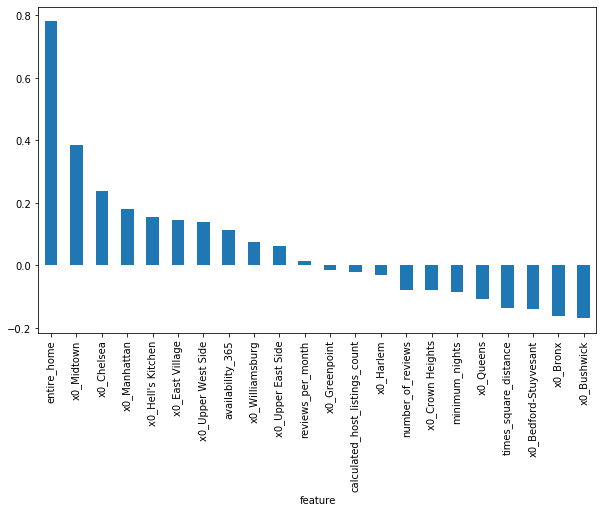

In [434]:
calculate_metrics_for_data_pipeline(Pipeline([
    ('compose', PandasFeatureUnion([
        ('numeric', make_numeric_selector()),
        ('entire_home', make_entire_home_selector()),
        ('neighbourhood', make_neighbourhood_select(700))
    ]))
]))

Теперь тоже самое, но граница района понизится с 700 до 200.

,error_type,naive,LinearRegression,LassoCV,ElasticCV,RidgeCV
0,MAE,81.311946,59.028353,59.079550,59.078169,59.027184
1,RMSE,200.288507,180.971318,180.868114,180.868171,180.968746
2,R2,-0.050487,0.142373,0.143351,0.143351,0.142398
3,MAPE,57.391880,36.170757,36.469275,36.493518,36.174677


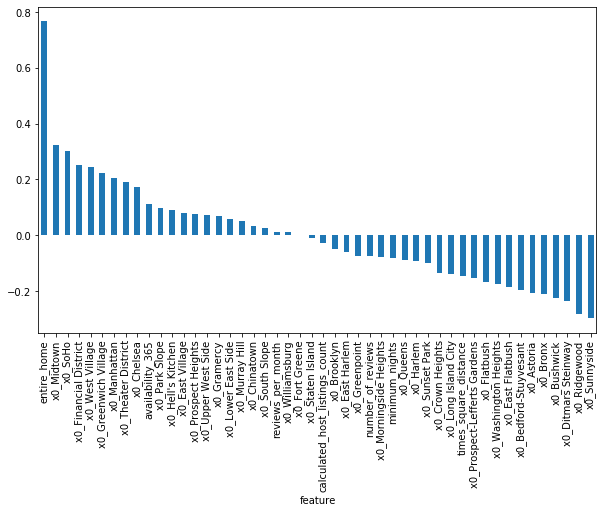

In [435]:
calculate_metrics_for_data_pipeline(Pipeline([
    ('compose', PandasFeatureUnion([
        ('numeric', make_numeric_selector()),
        ('entire_home', make_entire_home_selector()),
        ('neighbourhood', make_neighbourhood_select(200))
    ]))
]))

Теперь попробую обучится просто на всех районах.

,error_type,naive,LinearRegression,LassoCV,ElasticCV,RidgeCV
0,MAE,81.311946,57.986392,58.085449,58.083874,57.942982
1,RMSE,200.288507,179.837255,180.363950,180.430583,179.880691
2,R2,-0.050487,0.153088,0.148120,0.147491,0.152679
3,MAPE,57.391880,34.904390,35.133738,35.156944,34.845333


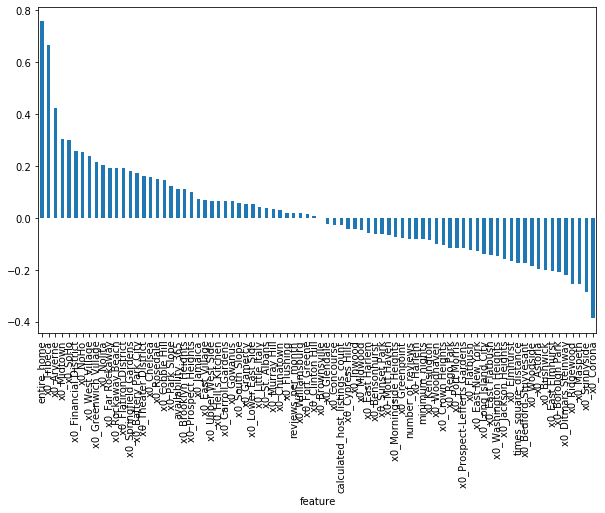

In [436]:
calculate_metrics_for_data_pipeline(Pipeline([
    ('compose', PandasFeatureUnion([
        ('numeric', make_numeric_selector()),
        ('entire_home', make_entire_home_selector()),
        ('neighbourhoo}d', Pipeline([
            ('select', make_select(['neighbourhood'])),
            ('ohe', OneHotEncodingDf(handle_unknown='ignore'))
        ]))
    ]))
]))

Результат получился выше чем с переделкой районов. Теперь попробую добавить neighbourhood_group в дополнение к районам.

In [442]:
# Сломал всю голову в попытках понять почему это не работает.
# calculate_metrics_for_data_pipeline(Pipeline([
#     ('compose', PandasFeatureUnion([
#         ('numeric', make_numeric_selector()),
#         ('entire_home', make_entire_home_selector()),
#         ('neighbourhood', Pipeline([
#             ('select', make_select(['neighbourhood', 'neighbourhood_group'])),
#             ('ohe', OneHotEncodingDf(handle_unknown='ignore'))
#         ]))
#     ]))
# ]))

/Users/andreyryabov/opt/anaconda3/envs/otus_ml/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

Результат оказался еще лучше. Попробую убрать разделение Entire home и вернуть room_type

,error_type,naive,LinearRegression,LassoCV,ElasticCV,RidgeCV
0,MAE,81.311946,57.813776,57.932901,57.928058,57.758796
1,RMSE,200.288507,179.755812,180.218752,180.269192,179.780490
2,R2,-0.050487,0.153855,0.149491,0.149015,0.153623
3,MAPE,57.391880,34.476781,34.627788,34.636465,34.416905


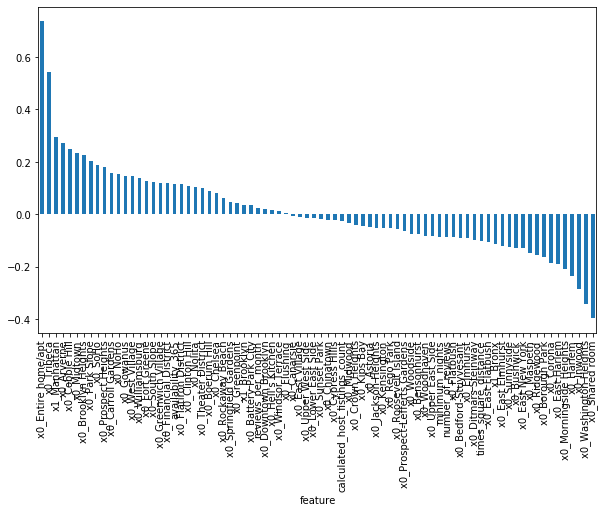

In [443]:
calculate_metrics_for_data_pipeline(Pipeline([
    ('compose', PandasFeatureUnion([
        ('numeric', make_numeric_selector()),
        ('room_type', Pipeline([
            ('select', make_select(['room_type'])),
            ('ohe', OneHotEncodingDf(sparse=False, handle_unknown='ignore'))
        ])),
        ('neighbourhood', Pipeline([
            ('select', make_select(['neighbourhood', 'neighbourhood_group'])),
            ('ohe', OneHotEncodingDf(sparse=False, handle_unknown='ignore'))
        ]))
    ]))
]))

# Вывод
1) Больше всего на цену влияет признак разделяющий целый дом или только его часть
2) Другая фича из начального датасета которая влияет на цену это availability_365. Подозреваю смысл в том, что чем дороже жилье тем больше оно простаивает
3) Фича с удаленностью от Таймс Сквер тоже неплохо себя показала
4) Остальное вычисление цены практически целиком ложится на конкретные районы. Самое дорогое жилье в Tribeca, самое дешевое в Washington Heights, Inwood, Harlem